# CS 3630 Project 4: Object Detection and Path Planning (Spring 2023)

---

# **Introduction**

In this project, you will implement a convolutional neural network to classify Japanese calligraphy characters, and use it to perform as triggers to move around the museum with RRT path planning.
You will use the generated paths on a differential drive robot to move around. 

Start early - this project has a lot of coding components!!

## Project `.ipynb` File Download Instructions
Instructions
In order to submit a file, once you complete the project:
1. Click the “File” button on the toolbar at the top
2. Click “Download,”
3. And then click “Download .ipynb”
4. You will now have the .ipynb file on your local machine.
5. Make sure it is named `project4.ipynb`
6. Submit the `project4.ipynb` file along with the generated `checkpoint.pt` file to Gradescope

## Report Instructions
Complete the __Project 4 - Report__ online assignment on Gradescope. Report questions answered in this notebook will not be considered.

---


# **Submission Details**

## Submission Deadlines
- Due: Friday, Mar 17 at 11:59PM on gradescope
- Late due date: Sun, Mar 19 at 11:59PM
- Hand-in: through Gradescope

## Code Submission Instructions
Submit the following **two** files to ***Project4 - Code*** on Gradescope:
 * __project4.ipynb__ - exported from Google Colab
 * __checkpoint.pt__ - saved from Google Colab (this is in Files (file icon on the left menu bar) --> checkpoints/checkpoint.pt)

## Report Submission Instructions 
Complete the ***Project 4 - Report*** online assignment on Gradescope. Report questions answered in this notebook will not be considered.

# Grading Rubric
 * Coding - 52 points 
 * 15 points: Correct implementation of LeNet and achieving above 93% test accuracy
 * 22 points: Correct implementation of RRT and its components + Path smoothing
 * 10 points: Correct implementation of differential drive components
 * 5 points: Correct implementation of path planning + object detection
 * Reflection - As on gradescope!
---



## **Collaboration Policy**
All projects in this course this semester are individual projects, which means ***no collaboration is allowed***.
However, you can discuss the projects and the reflection questions at a high level with your classmates or
the TAs. You can also ask questions on Piazza or go to office hours for help. All the code and all the
answers to the reflection questions must be your own.



# Part 1: Object Detection with Deep Learning

Setup
-------

The below cell imports the required libraries for this assignment.

In [ ]:
import os
import time
import torch
import torch.nn as nn
import torchvision.datasets as datasets
import torch.optim as optim
import torchvision.transforms as transforms
from torch.utils.data import DataLoader
from torch.autograd import Variable
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt

# !pip install torchsummaryX --quiet
from torchsummaryX import summary as summaryX
from torchsummaryX import summary

# from torch.utils.tensorboard import SummaryWriter
# writer = SummaryWriter()
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

## k-MNIST Dataset

We will design and train a CNN to recognize Japanese characters! 

The [k-MNIST](https://github.com/rois-codh/kmnist) contains different Japanese hiragana characters written in different forms, and it is ready-to-load in PyTorch.

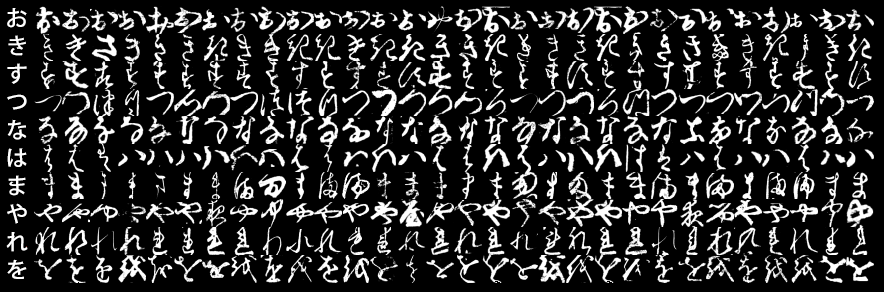

## Downloading the dataset

The below code downloads the train and test datasets.

In [ ]:
# download dataset
train_dataset = datasets.KMNIST(root='dataset/', train=True, transform=transforms.Compose([transforms.Pad(2), transforms.ToTensor()]), download=True)
test_dataset = datasets.KMNIST(root='dataset/', train=False, transform=transforms.Compose([transforms.Pad(2), transforms.ToTensor()]), download=True)

## Familiarizing yourself with the data

You can explore the images in the dataset by running the cell below. Familiarize yourself with the data structure of the dataset. 

The dataset (both train and test) are a list of tuples, with each tuple containing the image in pytorch tensor and the label. 

In [ ]:
# Visualizing one of the characters in the dataset
img_np = test_dataset[0][0] # An image in the dataset
print(test_dataset[0][1]) # Corresponding label of the image
plt.imshow(img_np[0], cmap='Greys_r')
print(img_np.shape)

## Intro to PyTorch: Simple CNN Model

For this assignment you will use PyTorch to build a neural network. 
Please go through the [PyTorch tutorials](https://pytorch.org/tutorials/beginner/basics/quickstart_tutorial.html) before you move on.  

We have provided an example of a simple CNN implementation in PyTorch to help you get familiar with network architecture creation.  

This simple neural network has two convolution layers and one fully connected layer, and you can see the size of the layers and the output after each layer by running the following code block.

Note1: Pytorch takes care of backpropagation automatically - all you have to do is define the forward pass part of the network. 

Note2: In all the models used in the assignment, you will come across a "nn.Linear" layer. This is simply a Fully Connected (FC) layer.

In [ ]:
class SimpleNet(nn.Module):
    def __init__(self):
        super(SimpleNet, self).__init__()
        '''
        Init function to define the layers
        '''
        self.conv1 = nn.Conv2d(in_channels = 1, out_channels = 5, 
                              kernel_size = 5, stride = 3, padding = 0)
        self.conv2 = nn.Conv2d(in_channels = 5, out_channels = 48, 
                              kernel_size = 5, stride = 1, padding = 0)
        self.linear1 = nn.Linear(48, 10)

        self.relu = nn.ReLU()

        self.avgpool = nn.AvgPool2d(kernel_size = 2, stride = 2)

    def forward(self, x):
        ''' Performs forward pass with the network.

        Args:
            x: input image of shape (N,C,H,W)
               - N: size of the batch, e.g. number of images
               - C: number of channels, 1 for grayscale images
               - H: height of image
               - W: width of image
        Returns:
            model_output: the output (raw scores) of shape (N,10)

        Note:
            Gradients will be handled automatically with PyTorch.
        '''
        # construct forward pass
        # x: input matrix
        x = self.conv1(x)
        x = self.relu(x)
        x = self.avgpool(x)
        x = self.conv2(x)
        x = self.relu(x)
        x = x.reshape(x.shape[0], -1)
        x = self.linear1(x)
        return x

# construct the model(e.g. neural network)
model = SimpleNet().to(device)
model
# model summary
#summary(model, (1,32,32))

## Reflection Questions
Q1 What is the shape of the feature map after an image from the kMNIST dataset is passed through the first convolution layer of SimpleNet? (self.conv1)? [Answer as (No. of Channels, Height, Width)]
    
    1.1 Channels
    1.2 Height
    1.3 Width

Q2. Count the Number of Parameters:
  
    2.1. Relu Layer
    2.2. AvgPool2D
    2.3. The last Linear Layer (self.linear1)



## Defining hyper-parameters and setting up for training

Now we will train the network on the k-MNIST dataset. We first specify the hyper-parameters for training

In [ ]:
# Hyperparameters
learning_rate = 0.01
num_epochs = 5
batch_size = 64

# set dataset loader
train_loader = DataLoader(dataset=train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(dataset=test_dataset, batch_size=batch_size, shuffle=True)
dataset_sizes = {'train':len(train_dataset), 'test':len(test_dataset)}

# construct model
model = SimpleNet().to(device)

# loss function
criterion = nn.CrossEntropyLoss()

# define the optimizer
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

You need not understand the below cell. The TAs are providing this code for you. You are encouraged to read through it and understand it, but it's not required for the scope of this assignment. The functions defined in this cell are used later on.

One class and three functions are defined in the cell below - 

1. The "ProgressMonitor" class is to simply monitor the training progress of the model.
2. The "train_iter" function is used to train the model.
3. The "test_iter" function is used to test the model.
4. The "train_and_test" function is puts together the above two functions.

We will use hyperparameters, model, loss criterion and optimizer defined in the code above. Do not change any parameters above. 



In [ ]:
from IPython.display import HTML, display
class ProgressMonitor(object):   
    tmpl = """
        <p>Loss: {loss:0.4f}   {value} / {length}</p>
        <progress value='{value}' max='{length}', style='width: 100%'>{value}</progress>
    """
 
    def __init__(self, length):
        self.length = length
        self.count = 0
        self.display = display(self.html(0, 0), display_id=True)
        
    def html(self, count, loss):
        return HTML(self.tmpl.format(length=self.length, value=count, loss=loss))
        
    def update(self, count, loss):
        self.count += count
        self.display.update(self.html(self.count, loss))

def train_iter(model, train_dataloader):
    """ One iteration of training through the entire dataset.
    """
    running_loss = 0.0

    # set model to training mode
    model.train()

    # create a progress bar
    progress = ProgressMonitor(length=dataset_sizes["train"])

    for data in train_dataloader:
        inputs, labels  = data
        batch_size = inputs.shape[0]
      
        inputs = Variable(inputs.to(device))
        labels = Variable(labels.to(device))

        # zero out previous gradients
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)

        loss.backward()
        optimizer.step()
                    
        running_loss += loss.data * batch_size
        # update progress bar
        progress.update(batch_size, running_loss)
    
    return running_loss


def test_iter(model, test_dataloader):
    """ Test the current model on the test dataset.
    """
    # set model to evaluation mode
    model.eval()
    # Do not need gradients for testing
    test_loss = 0.0
    with torch.no_grad():
        for data in test_dataloader:
            inputs, labels  = data
            batch_size = inputs.shape[0]

            inputs = Variable(inputs.to(device))
            labels = Variable(labels.to(device))
            outputs = model(inputs)

            # calculate the loss
            optimizer.zero_grad()
            loss = criterion(outputs, labels)
    
            # update running loss value
            test_loss += loss.data * batch_size
    return test_loss

def train_and_test(model, criterion, optimizer, num_epochs, dataloaders, dataset_sizes, first_epoch=1):
    """ Train and test the neural network on the specified dataset for several iterations.
    """
    best_epoch = -1
    last_train_loss = -1
    plot_train_loss = []
    plot_test_loss = []
  
    for epoch in range(first_epoch, first_epoch + num_epochs):
        print('\nEpoch', epoch)
        
        # training
        running_loss = train_iter(model, dataloaders[0])
  
        epoch_loss = running_loss / dataset_sizes["train"]
        print('Training loss:', epoch_loss.item())
        plot_train_loss.append(epoch_loss.cpu())
  
        # testing
        test_loss = test_iter(model, dataloaders[-1])
  
        epoch_test_loss = test_loss / dataset_sizes["test"]
        print('Testing loss:', epoch_test_loss.item())
        plot_test_loss.append(epoch_test_loss.cpu())

    return plot_train_loss, plot_test_loss, model

The below code trains SimpleNet on the train set and performs testing on the test dataset.  
Both stages return a list of loss values at each epoch.  
Training will take under 2 minutes using the Colab GPU runtime. 

In [ ]:
train_losses, test_losses, model = train_and_test(model=model, criterion=criterion, optimizer=optimizer,
                                              num_epochs=num_epochs, dataloaders=[train_loader, test_loader], 
                                              dataset_sizes=dataset_sizes)

## Visualizing Losses

In this section you will plot the loss values of your training and test sets. You can use any plotting tool to do this, but matplotlib is recommended. The graph should have a general trend like this:  
<img src="https://i.imgur.com/fYg6lmt.png"> 

Points to note - 
  
1. The train and test loss should decrease over time.  
2. Please include the plot title, labels for the axes and a legend to distinguish train and test losses.  
3. You will copy the resulting plot for LeNet to answer reflection questions.

In [ ]:
def plot_losses(train_losses, test_losses):
    """
    Plots train and test loss curves.
    Note: use matplotlib or any library to plot the graph
          Include title, x/y labels, and legend in the plot
    Args:
        train_losses: list of train losses by epoch
        test_losses: list of test losses by epoch
    """
    # TODO 1
    ###############################################################################
    #                             START OF YOUR CODE                              #
    ###############################################################################
    x = [*range(len(train_losses))]
    fig, ax = plt.subplots(figsize=(5,4))
    ax.set_xlabel('Epoch #')
    ax.set_ylabel('Loss')
    ax.set_title('Model Loss')
    ax.plot(x, train_losses)
    ax.plot(x, test_losses)
    ax.legend(("Train", "Test"), shadow=False, fancybox=True)
    ###############################################################################
    #                              END OF YOUR CODE                               #
    ###############################################################################

In [ ]:
# plot loss graph for SimpleNet
plot_losses(train_losses, test_losses)

## Accuracy

This code prints the prediction accuracy of the model on the datasets. You will get testing accuracy of around 87% on SimpleNet. This is not enough for a reliable classification.

In the next section, you will implement the classic CNN - LeNet, which will give you a better accuracy.

In [ ]:
def accuracy(loader, model, train=True):
    """
    Calculates prediction accuracy of the model on data
    
    Args:
        loader: (Dataloader) contains data and labels
        model: neural network model
        train (boolean): True if training, False if testing
    """
    num_correct = num_samples = 0
    model.eval()
    with torch.no_grad():
        for data in loader:
            inputs, labels  = data
            
            inputs = Variable(inputs.to(device))
            labels = Variable(labels.to(device))
            outputs = model(inputs)
            # prediction with the top score
            _, preds = outputs.max(1)
            num_correct += (preds == labels).sum()
            num_samples += preds.size(0)
    accuracy = (num_correct.item()/num_samples)*100
    
    if train:
        print("Model Predicted {} correctly out of {} from training dataset, Accuracy : {:.2f}".format(num_correct.item(), num_samples, accuracy))
    else:
        print("Model Predicted {} correctly out of {} from testing dataset, Accuracy : {:.2f}".format(num_correct.item(), num_samples, accuracy))

In [ ]:
# Calculate accuracy
accuracy(train_loader, model)
accuracy(test_loader, model, train=False)

## Task 1: Implementing LeNet
<img src="https://i.imgur.com/PSnq4rR.gif">  

Now that you are familiar with PyTorch, you will implement LeNet which will be used to classify Japanese hiragana characters for this assignment.  

LeNet (or LeCunNet) is a venerable convolutional neural network proposed by Yann LeCun et al. in 1998. 
It is one of the pioneers of CNNs that kickstarted the development of deep learning. It was originally used to recognize handwritten digits in zip codes.  

Fortunately, compared to some of the recent deep neural networks, LeNet has a relatively simple architecture and is quick to train. Training LeNet on k-MNIST will take under 5 minutes in an Colab GPU environment for 10 epochs. 


<img src="https://miro.medium.com/max/700/1*lvvWF48t7cyRWqct13eU0w.jpeg">

The above picture summarizes the LeNet's architecture. LeNet is composed of three convolutional layers and three fully connected layers. Below is a break down of LeNet layer-by-layer.


### LeNet Architecture
S.No | Layers | Activation Function | Output Shape (Height, Width, Channels)
--- | --- | --- | ---
1 | Input Layer | -- | 32 x 32 x 1
2 | Conv2d [6 Filters of size = 5x5, stride = 1, padding = 0 ] | Tanh | 28 x 28 x 6
3 | Average Pooling [stride = 2, padding = 0] | -- | 14 x 14 x 6
4 | Conv2d [16 Filters of size = 5x5, stride = 1, padding = 0 ] | Tanh | 10 x 10 x 16
5 | Average Pooling [stride = 2, padding = 0] | -- | 5 x 5 x 16
6 | Conv2d [120 Filters of size = 5x5, stride = 1, padding = 0 ] | Tanh | 1 x 1 x 120
7 | Flatten vector| -- | 120 
8 | Linear2 Layer | Tanh | 84 
9 | Final Linear Layer | SoftMax | 10



Referring to the network visualization and table above, fill in the `__init__` and `forward` in `class LeNet` (below the Reflection Questions section). Since PyTorch takes care of the backward pass part, you will only have to code the forward pass in `forward`. You can take a look at the official documentation for the modules you will use:
1. [nn.Conv2d](https://pytorch.org/docs/stable/generated/torch.nn.Conv2d.html)
2. [nn.Linear](https://pytorch.org/docs/stable/generated/torch.nn.Linear.html)
3. [nn.AvgPool2d](https://pytorch.org/docs/stable/generated/torch.nn.AvgPool2d.html)
4. [nn.ReLU](https://pytorch.org/docs/stable/generated/torch.nn.ReLU.html)

**Note** - In the original LeNet model, the Tanh activation function was used. However, for the scope of this assignment, we use the ReLU activation function due to its superior performance.


### Reflection Questions

Q3.1 - 3.3 What will be the size of the output when we apply the nn.AvgPool2d function on an input image of dimension [3x466x700]? The kernel size is 4x4, stride is 2 and padding is 1.

    3.1 Dimension 1
    3.2 Dimension 2
    3.3 Dimension 3

Q3.4 In one line, explain what padding is and why you need it?


In [ ]:
class LeNet(nn.Module):
    def __init__(self):
        '''
        Init function to define the layers
        '''
        super(LeNet, self).__init__()
        # TODO 2.1
        ###########################################################################
        # Student code begin
        ###########################################################################
        self.conv_layers = nn.Sequential(
            nn.Conv2d(in_channels = 1, out_channels = 6, kernel_size = 5, stride = 1, padding = 0),
            nn.ReLU(),
            nn.AvgPool2d(kernel_size = 1, stride = 2, padding = 0),

            nn.Conv2d(in_channels = 6, out_channels = 16, kernel_size = 5, stride = 1, padding = 0),
            nn.ReLU(),
            nn.AvgPool2d(kernel_size = 1, stride = 2, padding = 0),

            nn.Conv2d(in_channels = 16, out_channels = 120, kernel_size = 5, stride = 1, padding = 0),
            nn.ReLU(),
            nn.Flatten()
        )

        self.fc_layers = nn.Sequential(
            nn.Linear(in_features=120, out_features=84),
            nn.ReLU(),
            nn.Linear(in_features=84, out_features=10),
            nn.Softmax(dim=1)
        )
        ###########################################################################
        # Student code end
        ###########################################################################

    def forward(self, x):
        '''
        Performs forward pass with the network

        Args:
            x: input image of shape (N,C,H,W)
        Returns:
            model_output: the output (raw scores) of shape (N,10)
        '''
        model_output = None
        # TODO 2.2
        ###########################################################################
        # Student code begin
        ###########################################################################
        x = self.conv_layers(x)
        x = x.reshape(x.shape[0], -1)
        model_output = self.fc_layers(x)
        ###########################################################################
        # Student code end
        ###########################################################################
        return model_output

model = LeNet().to(device)
model

Run the unit test below to check if your network implementation is correct.  
The tests check if you have all the correct layer components, and if the output size is correct. 

In [ ]:
#DO NOT CHANGE THIS PART

import unittest

class TestLeNet(unittest.TestCase):
  def test_layers(self):
    convcnt, lincnt, relucnt, poolcnt = 0,0,0,0
    for name, layer in model.named_modules():
      if isinstance(layer, nn.Conv2d):
        convcnt += 1
      if isinstance(layer, nn.Linear):
        lincnt += 1
      if isinstance(layer, nn.ReLU):
        relucnt += 1
      if isinstance(layer, nn.AvgPool2d) or isinstance(layer, nn.MaxPool2d):
        poolcnt += 1
    assert convcnt >= 3
    assert lincnt >= 2
    assert relucnt >= 1
    assert poolcnt >= 1

  def test_output(self):
    inputs = torch.randn(5,1,32,32).to(device)
    outputs = model(inputs)
    assert (inputs.shape[0], 10) == outputs.shape

In [ ]:
suite = unittest.TestSuite()
suite.addTest(TestLeNet('test_layers'))
suite.addTest(TestLeNet('test_output'))
unittest.TextTestRunner().run(suite)

Now that you have the LeNet model ready, you can now train and test the model.

### Train and Test

In [ ]:
# Hyperparameters
# Only edit these values (for the reflection questions)!
learning_rate = 0.001
num_epochs = 25
batch_size = 128
#######################

# set dataset loader
train_loader = DataLoader(dataset=train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(dataset=test_dataset, batch_size=batch_size, shuffle=True)
dataset_sizes = {'train':len(train_dataset), 'test':len(test_dataset)}

# construct model
model = LeNet().to(device)

# loss function
criterion = nn.CrossEntropyLoss()

# define the optimizer
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

In [ ]:
# perform training and testing
train_losses, test_losses, model = train_and_test(model=model, criterion=criterion, optimizer=optimizer,
                                              num_epochs=num_epochs, dataloaders=[train_loader,test_loader], 
                                              dataset_sizes=dataset_sizes)

### Save and Load Model

Use the code below to save the model weights or load the pre-saved model that contains the trained model weights.  
You can use this to avoid training the network every time you re-load the Colab environment. 
Make sure you download the `checkpoint.pt` file locally as it will be deleted when the environment is reloaded. 

In [ ]:
# define the path to save/load the model
model_dir = 'checkpoints/'
if not os.path.exists(model_dir):
    os.mkdir(model_dir)

def save_model(model_dir):
    '''
    Saves the model state and optimizer state on the dict
    Change model_dir to the to save different model weights
    ex) 'SimpleNet_checkpoints', 'LeNet_checkpoints'
    '''
    if not os.path.exists(model_dir):
        os.mkdir(model_dir)
    torch.save({
        'model_state_dict': model.state_dict(),
        'optimizer_state_dict': optimizer.state_dict()
    }, os.path.join(model_dir, 'checkpoint.pt'))
    print('model saved at', model_dir + 'checkpoint.pt')

def load_model(model_dir, load_optimizer=False):
    '''
    Load the model from the disk if it exists, skip if you don't need this part
    '''
    if os.path.exists(model_dir):
        checkpoint = torch.load(os.path.join(model_dir, 'checkpoint.pt'))
        model.load_state_dict(checkpoint['model_state_dict'])
        if load_optimizer:
            optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
        print('loaded model from saved checkpoint')

In [ ]:
# Uncomment as needed. Make sure to leave it commented before submitting the notebook to Gradescope.
# save_model(model_dir)
# load_model(model_dir)

Plot the loss curves using the `plot_losses` function you implemented earlier.  
You will paste the before/after tuning loss plots in the reflection powerpoint.

In [ ]:
# Plot your train and test losses
plot_losses(train_losses, test_losses)

Print train/test accuracy using the accuracy function. 


In [ ]:
accuracy(train_loader, model)
accuracy(test_loader, model, train=False)

## Task 2: Tuning the network

In this section you will tune the hyperparameters to improve the performance of LeNet.

In task 1 you trained the network with the provided default parameters.  

Now, you will play with the hyperparameters (check below in the Reflection Question section for possible values) to improve the accuracy of the network. Training this network should usually take under 5 minutes (ideally around 2 minutes) on Colab with the GPU runtime.

Note that simply increasing the number of epochs unreasonably will not help much.

You will have to achieve over 93% test accuracy in order to get full points. 

### Reflection Questions

Q4.1 Try different combinations for the set of hyperparamters: 
  - batch_size = {32, 64, 128}
  - learning_rate = {0.01,0.05,0.005, 0.001}

You may also increase the number of epochs.
Which set of parameters worked best for you? Explain your findings.

Q4.2 Paste a screenshot (under Q1.6 in Project 4 - Report on Gradescope) showing the loss vs epoch of your LeNet. State the train and test accuracies.

Q4.3 What happens to your test accuracy if you set the learning rate to 0.001, and gradually increase the batch_size from 32 to 64 to 128? Please provide a reasoning for what you see.

## Inference on Custom Image

In this section, you will see if your trained network actually works in classifying hiragana characters!

You will complete the `classify_image` function in the `ImageClassifier` class below. The function takes a 32x32 image as input, and return a number ranging from 0-9, which will then be mapped to a character. 

Below is a classmap of the 10 labels for better understanding.  

index | unicode | char | pronunciation
:-: | :-: | :-: | :-:
0 | U+304A | お | a
1 | U+304D | き | ki
2 | U+3059 | す | su
3 | U+3064 | つ | tsu
4 | U+306A | な | na
5 | U+306F | は | ha
6 | U+307E | ま | ma
7 | U+3084 | や | ya
8 | U+308C | れ | re
9 | U+3092 | を | o


Brief explanation of the functions in the class - 

1. `__init__` - Defines the CNN model being used and the mapping from index to character.
2. `classify_image` - Forward pass the image input through the trained model and return the output.
3. `character` - Takes an image as input, calls the `classify_image` function, and maps its output to the corresponding character, and outputs that.

For your curiosity, you can find the pronunciation of each of the characters and more [here](https://www.thoughtco.com/how-to-pronounce-hiragana-japanese-hiragana-with-audio-files-4077351)

In [ ]:
class ImageClassifier:
    """
    Classify the image and provide the label of the character.
    """
    def __init__(self, model):
        self.model = model
    
        # index and corresponding character unicode
        self.labels_dict = dict([(0, u"\u304A"), (1, u"\u304D"), (2, u"\u3059"), 
                                 (3, u"\u3064"), (4, u"\u306A"), (5, u"\u306F"), 
                                 (6, u"\u307E"), (7, u"\u3084"), (8, u"\u308C"), 
                                 (9, u"\u3093")])

    def classify_image(self, image):
        """ Classify the image of calligraphy character.

        Args:
            image (torch.Tensor) image tensor of size (1,32,32)

        Returns:
            int: classified label of the image
        
        Note:
            You can refer to accuracy() function to see how to forward pass
            the image input through the model and get the output
        """
        image_tensor = image.clone()
        image_tensor.unsqueeze_(0)
        # TODO 3
        ###############################################################################
        #                             START OF YOUR CODE                              #
        ###############################################################################
        # hint: you will need to change the device of the output tensor of the model from 
        # the gpu(cuda) to cpu. Using the command {output}.cpu() will do this.
        image_tensor = image_tensor.to(device)
        output = self.model(image_tensor)
        output = output.cpu()
        index = output.argmax(dim=1).item()
        ###############################################################################
        #                              END OF YOUR CODE                               #
        ###############################################################################

        return index

    def character(self, image):
        return self.labels_dict[self.classify_image(image)]

image_classifier = ImageClassifier(model)

# test the classifier on an image
img_index = np.random.randint(10000)
image = test_dataset[img_index][0]
label = test_dataset[img_index][1]
plt.imshow(image[0], cmap='Greys_r')
print('Prediction: ', image_classifier.character(image))
print('Target: ', image_classifier.labels_dict[label])

# Part 2: RRT with Object Detection

<img src="https://i.imgur.com/5VyGkRp.jpg" width="400px">

In this section you will implement Rapidly-exploring Random Tree (RRT) to make a robot navigate in a map of a museum. A visualization of a museum with obstacles is provided to help you better understand the tree formation and path planning process.

## Setup

The following code block provides helpers and visualization functions for the environment. You can simply run it, and there's no need to read through all the contents.  
Read through the `Wall` and `Image` classes, `env_walls` and `env_images` functions as you will use them in the later sections.  
Below are brief explanations for each components:
1. `Class Wall`: Creates a wall rectangle with its start/end points and location.
2. `Class Image`: Creates an image rectangle with its location, orientation, and label. The `sample` function gets an image corresponding to the label from the MNIST dataset.
3. `env_walls`: Returns a list of walls in the map.
4. `env_images`: Returns a list of images in the map.

Note: if you saved your model from Part 1, you can simply upload the `checkpoint.pt` file, load the model, construct `image_classifier`, and start from this step.

In [ ]:
# importing necessary modules for factor graph optimization and visualization
# !pip install -q plotly gtsam
import gtsam
import numpy as np
import plotly.graph_objects as go
from tqdm import trange
import torch
import torchvision.datasets as datasets
import torchvision.transforms as transforms
import os
import math

########################## load utils ##########################
# !pip install --upgrade --no-cache-dir gdown &> /dev/null
# !gdown 1HPgmz58DC7wJzPx7HFVdZBZ_owycob4B
# !pip install shapely==1.8
from utils import *

########################## load dataset ##########################
test_dataset = datasets.KMNIST(root='dataset/', train=False, transform=transforms.Compose([transforms.Pad(2), transforms.ToTensor()]), download=True)
image_classifier = ImageClassifier(model)

########################## environment helpers ##########################

def rect(x_m, y_m, xsize_m, ysize_m, rgba=None):
    return dict(
        type='rect',
        x0=x_m, y0=y_m,
        x1=x_m + xsize_m, y1=y_m + ysize_m,
        fillcolor=f"rgba({rgba[0]}, {rgba[1]}, {rgba[2]}, {rgba[3]})" if rgba else "rgb(255, 255, 255)",
        line_width=0,
        layer="below"
    )


class Image:
    '''
    Class for images in the KMNIST dataset
    '''
    def __init__(self, location, facing, image_label):
        '''
        location: [x,y] coordinate of the image location
        facing: (w/e/s/n) orientation of the image
        image_label: (0~9) label of the image
        '''
        self.facing = facing
        if facing == 'w':
            theta = np.pi
        elif facing == 'e':
            theta = 0
        elif facing == 's':
            theta = -np.pi/2
        elif facing == 'n':
            theta = np.pi/2
        self.wTi = gtsam.Pose2(location[0], location[1], theta)
        self.image_label = image_label
        self.location = location

    def sample(self):
        '''
        Samples a character corresponding to the image label from the dataset.
        Return: image tensor
        '''
        test_size = len(test_dataset)
        index = np.random.randint(0, test_size)
        while not test_dataset[index][1] == self.image_label:
            index = (index + 1) % test_size
        return test_dataset[index][0]

    def get_rect(self, color):
        if self.facing == 'w':
            xm = self.wTi.x() - 0.25
            ym = self.wTi.y() - 0.5
            xsize = 0.25
            ysize = 1
        elif self.facing == 'e':
            xm = self.wTi.x()
            ym = self.wTi.y() - 0.5
            xsize = 0.25
            ysize = 1
        elif self.facing == 's':
            xm = self.wTi.x() - 0.5
            ym = self.wTi.y() - 0.25
            xsize = 1
            ysize = 0.25
        elif self.facing == 'n':
            xm = self.wTi.x() - 0.5
            ym = self.wTi.y()
            xsize = 1
            ysize = 0.25

        return rect(xm, ym, xsize, ysize, color)


class Wall:
    '''
    Class for walls in the map.
    '''
    def __init__(self, start_point, end_point, color):
        '''
        start_point: [x,y] coordinate of the lower left corner of the rectangular wall
        goal_point: [x,y] coordinate of the top right corner of the wall
        '''
        self.ps = start_point
        self.pe = end_point
        self.color = color

    def get_rect(self):
        return rect(self.ps[0], self.ps[1], self.pe[0]-self.ps[0], self.pe[1]-self.ps[1], self.color)


def env_walls():
    '''
    Returns a list of obstacles in the map. 
    Each Wall class represents a rectangular obstacle in the map. 
    '''
    white = [255, 255, 255, 255]
    gray = [150, 150, 150, 255]
    wall_list = [Wall([0,-0.5], [16, 0], white),
                 Wall([0, 9], [16, 9.5], white),
                 Wall([-0.5, -0.5], [0, 9.5], white),
                 Wall([16, -0.5], [16.5, 9.5], white),
                 Wall([0, 4.25], [3, 4.75], gray),
                 Wall([5, 4.25], [11, 4.75], gray),
                 Wall([13, 4.25], [16, 4.75], gray),
                 Wall([7.75, 1.75], [8.25, 7.25], gray),
                 Wall([0, 0], [3, 1.75], gray),
                 Wall([13, 0], [16, 1.75], gray),
                 Wall([0, 7.25], [3, 9], gray),
                 Wall([13, 7.25], [16, 9], gray),
                 Wall([5, 7.25], [11, 7.75], gray),
                 Wall([5, 1.25], [11, 1.75], gray)]
    return wall_list

def env_images():
    '''
    Assigns images to specified position and orientation in the map.
    Returns a list of images
    '''
    images_list = [Image([0, 3], 'e', 0),
                   Image([7.75, 3], 'w', 1),
                   Image([0, 6], 'e', 2),
                   Image([7.75, 6], 'w', 3),
                   Image([4, 9], 's', 4),
                   Image([12, 9], 's', 5),
                   Image([8.25, 6], 'e', 6),
                   Image([16, 6], 'w', 7),
                   Image([8.25, 3], 'e', 8),
                   Image([16, 3], 'w', 9)]
    return images_list

### Reflection Questions
Q5 Read through the code in the Setup section. Answer the questions below.

Q5.1 How many obstacles are in the environment? Exclude the walls along the corners of the environment. 

Q5.2 What does the integer '0' in the images_list (ex. Image([1,3], ‘e’, 0) represent?

## Environment

Later, you will use the image classifier you trained to help the robot navigate in a museum. Run the following code block to see a map of the museum. There are calligraphy images (shown as rectangles) hanging on the wall shown in different colors.

Each of the ten image contains different kinds of japanese characters. 

Notice that the same calligraphy image may appear differently every time you initialize the environment, but it should always be the same character.

In [ ]:
class Environment:
    """ Simulation environment class.
    Initializes the room size, images, and obstacles. 
    """
    def __init__(self):
        self.room_size = (16, 9)
        self.image_list = env_images()
        self.wall_list = env_walls()

### Comment for autograder - do not delete!

env = Environment()

# visualize the environment
visualize(env)

### Comment for autograder end - do not delete!

## RRT Components

Here you will implement various components needed to run RRT. Some functions are already filled out for you.  
Unit tests are provided for every TODO below.  
A safe strategy before moving onto next components will be to check if you implemented a function correctly by running the corresponding unit test.  
Note that the provided unit tests may not be exhaustive. 

You will implement:
- `inObstacle` - checks if a node is within a obstacle
- `randomSample` - generates random point in the map
- `getNearest` - finds nearest node in the tree
- `stepTo` - takes a 'step' towards the random point from the nearest node in the tree
- `isCollision` - checks if a vertex collides with any obstacles
- `withinTolerance` - checks if a node is within tolerance of the goal position

In [ ]:
class Node:
    def __init__(self, point, parent=None):
        super(Node, self).__init__()
        '''RRT Node Class

        Parameters
        ----------
        point: numpy array [x,y]
        parent: parent Node class

        Notes
        -----
        You must use this node representation to build the tree. 
        '''
        self.point = point
        self.parent = None

    @property
    def x(self):
       return self.point[0]

    @property
    def y(self):
       return self.point[1]


def dist(node1, node2):
    '''Returns the distance between two nodes
    Parameters
    ----------
    node1, node2: two Node objects

    Returns
    -------
    Euclidean distance between two nodes
    '''
    return np.linalg.norm(node2.point - node1.point) 


def inObstacle(node, env):
    '''Returns True if the given node is within ANY obstacle
    Parameters
    ----------
    node: Node object
    env: Environment class
    
    Returns
    -------
    (boolean) True if the node is within any obstacle

    Notes
    -----
    Use env.wall_list to access the list of obstacles. You may loop through the
    obstacles to check if the given node is within the boundary of any obstacle.
    '''
    # TODO 4
    ###############################################################################
    #                             START OF YOUR CODE                              #
    ###############################################################################
    for wall in env.wall_list:
        x_min = min(wall.ps[0], wall.pe[0])
        x_max = max(wall.ps[0], wall.pe[0])
        y_min = min(wall.ps[1], wall.pe[1])
        y_max = max(wall.ps[1], wall.pe[1])
        if x_min <= node.x <= x_max and y_min <= node.y <= y_max:
            return True
    return False
    ###############################################################################
    #                              END OF YOUR CODE                               #
    ###############################################################################


def randomSample(goal_pos, env):
    '''Generates random point in the map. 
    Generated point should not be inside an obstacle.
    You should return the goal position with some probability. (e.g. 10%)

    Parameters
    ----------
    goal_pos: numpy array [x,y] of goal position
    env: Environment class

    Returns
    -------
    Node object containing randomly generated coordinates
    '''
    # TODO 5
    ###############################################################################
    #                             START OF YOUR CODE                              #
    ###############################################################################
    if np.random.rand() < 0.1:
        return Node(goal_pos)

    while True:
        x = np.random.uniform(0, env.room_size[0])
        y = np.random.uniform(0, env.room_size[1])
        random_node = Node(np.array([x, y]))
        if not inObstacle(random_node, env):
            return random_node
    ###############################################################################
    #                              END OF YOUR CODE                               #
    ###############################################################################
  

def getNearest(rrt_tree, random_point):
    '''Find the nearest node in the tree to the given point
    
    Parameters
    ----------
    rrt_tree: list of nodes in the RRT tree
    random_point (Node): randomly sampled node

    Returns
    -------
    nearest_node (Node): Existing node in the tree nearest to random_point
    '''
    # TODO 6
    ###############################################################################
    #                             START OF YOUR CODE                              #
    ###############################################################################
    nearest_node = rrt_tree[0]
    min_distance = dist(nearest_node, random_point)

    for node in rrt_tree:
        distance = dist(node, random_point)
        if distance < min_distance:
            min_distance = distance
            nearest_node = node

    ###############################################################################
    #                              END OF YOUR CODE                               #
    ###############################################################################

    return nearest_node

def stepTo(nearest_point, random_point, step=1.):
    '''Returns a node in the direction from nearest_point to random_point with a length 
    of 'step' from the nearest point. 
    Return random_point if the distance between two points is less than 'step'.

    Parameters
    ----------
    nearest_point (Node): nearest point inside tree to the random point
    random_point (Node): randomly sampled point
    step (float): maximum step size to the random point

    Return
    ------
    return: Node object with coordinate along the line segment
    
    Hint 
    ------
    It may be helpful to use np.arctan2 for this function
    
    '''
    # TODO 7
    ###############################################################################
    #                             START OF YOUR CODE                              #
    ###############################################################################
    distance = dist(nearest_point, random_point)
    if distance <= step:
        return random_point

    angle = np.arctan2(random_point.y - nearest_point.y, random_point.x - nearest_point.x)
    new_x = nearest_point.x + step * np.cos(angle)
    new_y = nearest_point.y + step * np.sin(angle)

    return Node(np.array([new_x, new_y]))
    ###############################################################################
    #                              END OF YOUR CODE                               #
    ###############################################################################

def isCollision(line, env):
    '''Check if the given vertex collides with any obstacles

    Parameters
    ----------
    line: Tuple of two nodes
    env: Environment class

    Return
    ------
    (boolean) True if the line passes through any of the obstacles.

    Note
    -----
    1. Use `line_intersection` to check for line collisions.
    You can find the docstring for line_intersection by typing 
    help(line_intersection) in a code cell.
    2. Use env.wall_list to call in a list of walls.
    '''
    # TODO 8
    ###############################################################################
    #                             START OF YOUR CODE                              #
    ###############################################################################
    for wall in env.wall_list:
        line1 = ((wall.ps[0], wall.ps[1]), (wall.ps[0], wall.pe[1]))
        line2 = ((wall.ps[0], wall.ps[1]), (wall.pe[0], wall.ps[1]))
        line3 = ((wall.pe[0], wall.ps[1]), (wall.pe[0], wall.pe[1]))
        line4 = ((wall.ps[0], wall.pe[1]), (wall.pe[0], wall.pe[1]))
        wall_lines = [line1, line2, line3, line4]

        for wall_line in wall_lines:
            if line_intersection(line[0].point, line[1].point, wall_line[0], wall_line[1]):
                return True
    return False
    ###############################################################################
    #                              END OF YOUR CODE                               #
    ###############################################################################
  

def withinTolerance(point, goal, tolerance=1.5):
    '''Check if a node is within tolerance of the goal.
    Parameters
    ----------
    point (Node)
    goal (Node): goal node
    tolerance (float): distance from goal point that is considered close enough

    Return
    ------
    (boolean) True if point is within tolerance
    '''
    # TODO 9
    ###############################################################################
    #                             START OF YOUR CODE                              #
    ###############################################################################
    return dist(point, goal) <= tolerance
    ###############################################################################
    #                              END OF YOUR CODE                               #
    ###############################################################################

Run the unit tests below to test each module. 
Note that these tests are not exhaustive. Passing the tests may not always mean that you implemented the functions correctly. 

In [ ]:
import unittest

class TestRRT(unittest.TestCase):
    def test_inObstacle(self):
        assert inObstacle(Node(np.array([4,3])), env) == False
        assert inObstacle(Node(np.array([14,1])), env) == True
        assert inObstacle(Node(np.array([8,3])), env) == True

    def test_randomSample(self):
        for _ in range(5):
            sample = randomSample(np.array([4,1]), env)
            assert 0 <= sample.x <= 16
            assert 0 <= sample.y <= 9
            assert inObstacle(sample, env) == False

    def test_getNearest(self):
        tree = [Node(np.array([4,3])), Node(np.array([6,2]))]
        nearest_node = getNearest(tree, Node(np.array([4,5])))
        assert (nearest_node.point == np.array([4,3])).all()

    def test_stepTo(self):
        node1 = Node(np.array([4,1]))
        node2 = Node(np.array([4,7]))
        node3 = Node(np.array([4,1.5]))

        assert dist(node1, stepTo(node1, node2)) == 1
        assert dist(node1, stepTo(node1, node3)) < 1


    def test_isCollision(self):
        start = Node(np.array([7,3]))
        end = Node(np.array([9,5]))
        assert isCollision((start,end), env)

        start = Node(np.array([14,3]))
        end = Node(np.array([15,4]))
        assert isCollision((start,end), env) == False

    def test_tolerance(self):
        assert withinTolerance(Node(np.array([0,0])), Node(np.array([0,2])), 3)
        assert withinTolerance(Node(np.array([0,0])), Node(np.array([0,2]))) == False

In [ ]:
### Comment for autograder - do not delete!
suite = unittest.TestSuite()
suite.addTest(TestRRT('test_inObstacle'))
suite.addTest(TestRRT('test_randomSample'))
suite.addTest(TestRRT('test_getNearest'))
suite.addTest(TestRRT('test_stepTo'))
suite.addTest(TestRRT('test_isCollision'))
suite.addTest(TestRRT('test_tolerance'))
unittest.TextTestRunner().run(suite)
### Comment for autograder end - do not delete!

## RRT

Using the components you wrote above, complete the RRT algorithm.  
RRT should  
* sample a random point
* find the nearest point in the tree
* step towards the sampled point
* add the point to the tree

Think about when you should terminate the algorithm and generate a path.  
Also, remember to check for collisions for generated vertices or if a point is in an obstacle. 

In [ ]:
def RRT(start_pos, goal_pos, env):
    '''Implement RRT to find a path to the goal position. 
    Parameters
    ----------
    start_pos (np.array): [x,y] start position
    goal_pos (np.array): [x,y] goal coordinate
    env: Environment class

    Return
    ------
    list of nodes representing the path from source to goal node

    Note
    ----
    To find the path in the tree, you will need to backtrack from the node closest
    to the goal node to the root node. 
    '''
    root = Node(start_pos)
    goal_node = Node(goal_pos)
    rrt_tree = [root]
    # soln_node should contain the goal node at the end of your RRT procedure
    soln_node = None
    # TODO 10
    ###############################################################################
    #                             START OF YOUR CODE                              #
    ###############################################################################
    while soln_node is None:
        sample = randomSample(goal_pos, env)
        nearest_node = getNearest(rrt_tree, sample)
        new_node = stepTo(nearest_node, sample)

        if not isCollision((nearest_node, new_node), env):
            new_node.parent = nearest_node
            rrt_tree.append(new_node)

            if withinTolerance(new_node, goal_node):
                soln_node = new_node

    path = []
    while soln_node:
        path.insert(0, soln_node)
        soln_node = soln_node.parent
    ###############################################################################
    #                              END OF YOUR CODE                               #
    ###############################################################################

    return path, rrt_tree

## Visualize RRT and path

Check if your RRT is running right by visualizing the RRT tree in the map.
You can change the start and goal positions to test the tree generation in different locations. It may take a bit long to visualize a tree for a goal position far from the starting position. 

In [ ]:
### Comment for autograder - do not delete!
start_pos = np.array([4,1])
goal_pos = np.array([0,6])
path, rrt_tree = RRT(start_pos, goal_pos, env)

visualize_tree(env, rrt_tree)
### Comment for autograder end - do not delete!

Now visualize the path to the goal you found from the RRT. 
The code below visualizes and animates the found path frame by frame. 

In [ ]:
### Comment for autograder - do not delete!
visualize_path(env,path)
### Comment for autograder end - do not delete!

## Path smoothing 
You will notice from the visualization above that the generated path is not always the shortest path to the goal, and the paths are in a jagged pattern.
Here you will apply smoothing to connect non-consecutive vertices and form a new edge that does not collide with the obstacles.  
`smoothPath` below takes in a path generated by RRT and return a smoothed path. You may need to run through a loop to find possible paths that can be smoothed.

In [ ]:
def smoothPath(path, env, iters=10):
    '''Returns a smoothed version of the given path.
    Parameters
    ----------
    path: list of nodes
    env: Environment class
    iters (int): number of iterations

    Return
    ------
    path: list of nodes 

    Note
    ----
    Remember to check if the new path collides with any obstacles
    '''
    # TODO 11
    ###############################################################################
    #                             START OF YOUR CODE                              #
    ###############################################################################
    for _ in range(iters):
        choice1 = np.random.randint(0, len(path) - 2)
        choice2 = np.random.randint(choice1 + 2, len(path))
        node1 = path[choice1]
        node2 = path[choice2]

        if not isCollision((node1, node2), env):
            path[choice1 + 1:choice2] = [node2]
            node1.parent = node2
    ###############################################################################
    #                              END OF YOUR CODE                               #
    ###############################################################################
    
    return path

Visualize the new path after smoothing is applied. Compare to the generated path before smoothing. What changes to you observe?

In [ ]:
### Comment for autograder - do not delete!
visualize_path(env,smoothPath(path, env))
### Comment for autograder end - do not delete!

## Reflection Questions
Q6.1 When randomly sampling points for RRT, what is the purpose of returning the goal position with some probability?

Q6.2 Write the high-level pseudocode for the RRT algorithm. Add an explanation of each step beside the pseudocode.

Q6.3 What is the most costly part of the RRT algorithm? Please explain why.

Q6.4 Attach a screenshot of the rapidly-exploring random tree (RRT) generated to find the path from [4,1] to goal position [0,6].

Q6.5 Attach a screenshot of the path found from the tree in Q6.4 **without** path smoothing.

Q6.6 Attach a screenshot of the path found from the tree in Q6.4 **with** path smoothing. Explain the differences with and without smoothing.

# Part 3: Differential Drive

The robot used to move around is a differential drive robot; the robot has two wheels that can move at different speeds. Here you will implement some functions that generate speed commands for each wheel so the robot can move along the paths generated by RRT.


## Implementing Differential Drive
You will implement the following functions:
1. rotate(): In this function you will calculate the wheel velocities of the robot (using the ddr_ik() function. [Link to Book](https://www.roboticsbook.org/S52_diffdrive_actions.html#kinematics-in-code)) and also the time duration for the robot to perform pure rotation to orient itself from its current heading to the heading of the next point. You might find [np.arctan2()](https://numpy.org/doc/stable/reference/generated/numpy.arctan2.html) useful to find the angle required to rotate. The angle should be between 0 and $2\pi$, so might need to make some adjustments.
2. forward(): In this function you will calculate the wheel velocities of the robot (using the ddr_ik() function. [Link to Book](https://www.roboticsbook.org/S52_diffdrive_actions.html#kinematics-in-code)) and also the time duration for the robot to perform pure translation to reach from current position to the next point.

In [ ]:
def ddr_ik(v_x, omega, L=0.5, r=0.1):
    """DDR inverse kinematics: calculate wheels speeds from desired velocity. You find the function in book's section 5.2
    
    v_x (float): Translational velocity of the robot
    omega (float): Angular velocity of the robot
    L (float): Distance between robot wheels
    r (float): Wheel radius of robot    
    
    """
    return (v_x - (L/2)*omega)/r, (v_x + (L/2)*omega)/r


def rotate(init_pose, point, omega=2):

    '''
    Function to perform pure rotation of robot to correct heading based on init_pose and point
    Hint: (i) What should v_x be in ddr_ik() for pure rotation?
          (ii) You might find np.arctan2() usefull in finding the angle to rotate


    init_pose (gtsam.Pose2): Initial Pose from where the robot starts. Given as (x,y,theta)
                              You can get x as init_pose.x().
    point [float,float]: Destination Point of the robot. Given as [x,y]
    omega: angular velocity in radians per second #DO NOT CHANGE

    Return:
    v_L (float): Left wheel velocity
    v_R (float): Right wheel velocity
    t (float): time duration for which the robot should use these velocities

    '''
    # TODO 12
    ###############################################################################
    #                             START OF YOUR CODE                              #
    ###############################################################################
    x, y = init_pose.x(), init_pose.y()

    dx = point[0] - x
    dy = point[1] - y
    heading = np.arctan2(dy, dx) % (2 * np.pi)
    v_L, v_R = ddr_ik(0, omega)

    t = abs(heading)/omega
    ###############################################################################
    #                              END OF YOUR CODE                               #
    ###############################################################################

    return v_L,v_R, t

  
def rotateRobot(init_pose, v_L, v_R, t, L=0.5, r=0.1):
    '''
    Generates intermediate robot poses based on wheel velocities, useful for visualization

    init_pose (gtsam.Pose2): Initial Pose from where the robot starts. Given as (x,y,theta)
    v_L (float): Left wheel velocity
    v_R (float): Right wheel velocity
    t (float): time duration for which the robot should use these velocities
    L (float): Distance between robot wheels
    r (float): Wheel radius of robot

    '''

    init_theta = init_pose.theta()
    angle_turned = 0
    poses = []
    N = 1
    for _ in range(N):
        angle_turned += (v_R-v_L)*t*r/(L*N) % (2*math.pi)
        poses.append(gtsam.Pose2(init_pose.x(),init_pose.y(), angle_turned))

    return poses

def forward(init_pose, point, V=1):

    '''
    Function to perform pure translation of robot to point
    Hint: What should omega in ddr_ik() be in case of pure translation?

    init_pose (gtsam.Pose2): Initial Pose from where the robot starts as (x,y,theta)
                              You can get x as init_pose.x().
    point [float,float]: Destination Point of the robot. Given as [x,y]
    V: Translational Velocity of robot #DO NOT CHANGE

    Return:
    v_L (float): Left wheel velocity
    v_R (float): Right wheel velocity
    t (float): time duration for which the robot should use these velocities

    '''
    # TODO 13
    ###############################################################################
    #                             START OF YOUR CODE                              #
    ###############################################################################
    x_diff = point[0] - init_pose.x()
    y_diff = point[1] - init_pose.y()
    dist = np.sqrt(x_diff**2 + y_diff**2)

    omega = 0
    v_L, v_R = ddr_ik(V, omega)
    t = dist / V
    ###############################################################################
    #                              END OF YOUR CODE                               #
    ###############################################################################

    return v_L, v_R, t


def forwardRobot(init_pose, v_L, v_R, t, L=0.5, r=0.1):
    '''
    Generates intermediate robot poses based on wheel velocities, useful for visualization
    
    v_L (float): Left wheel velocity
    v_R (float): Right wheel velocity
    t (float): time duration for which the robot should use these velocities
    L (float): Distance between robot wheels
    r (float): Wheel radius of robot
    '''
    x = init_pose.x()
    y = init_pose.y()
    poses = []
    N = 5

    for i in range(N):
        x += v_L*math.cos(init_pose.theta())*t*r/N
        y += v_L*math.sin(init_pose.theta())*t*r/N

        poses.append(gtsam.Pose2(x,y,init_pose.theta()))

    return poses
    

def moveRobot(init_pose: gtsam.Pose2, path):
    '''
    move robot along given path
    init_pose (gtsam.Pose2): Starting pose (x,y,theta) of the robot
    path: path found from RRT

    return: list of poses along the given path
    '''
    poses = [init_pose]
    
    for i in range(1, len(path)):
        curr_pose = poses[-1]
        next_x, next_y = path[i].point
        v_L, v_R, t = rotate(curr_pose, [next_x, next_y])
        poses += rotateRobot(curr_pose, v_L, v_R, t)
        v_L,v_R, t = forward(poses[-1], [next_x, next_y])
        poses+= forwardRobot(poses[-1], v_L,v_R, t)

    return poses
       

Test robot to move to a designated goal position. 

In [ ]:
### Comment for autograder - do not delete!
starting_pose = gtsam.Pose2(4, 1, np.pi/2)
path, rrt_tree = RRT(np.array([starting_pose.x(), starting_pose.y()]), np.array([0,6]), env)
poses = moveRobot(starting_pose, path)
visualize(env, poses)
### Comment for autograder end - do not delete!

In [ ]:
import unittest

class TestDiffDrive(unittest.TestCase):
    def test_rotate(self):
        starting_pose = gtsam.Pose2(4,1,np.pi/2)

        points = [[3.37530495, 1.78086881],
                  [2.7506099,  2.56173762]
                  ]
        v_list = []
        for point in points:
          v_list.append(list(rotate(starting_pose,point)))

        v_list_np = np.array(v_list)
        desired_v_np = np.array([[-5.0, 5.0, 1.1227686352900934],
                      [-5.0, 5.0, 1.1227686352900934],
                    ])
        np.testing.assert_almost_equal(v_list_np,desired_v_np)

    def test_forward(self):
      starting_pose = gtsam.Pose2(4,1,np.pi/2)

      points = [[3.37530495, 1.78086881],
                  [2.7506099,  2.56173762]
                  ]
      v_list = []
      for point in points:
          v_list.append(list(forward(starting_pose,point)))

      v_list_np = np.array(v_list)
      desired_v_np = np.array([[10.0, 10.0, 1.0000000019626594], 
                                [10.0, 10.0, 2.0000000039253187], 
                                ])
      np.testing.assert_almost_equal(v_list_np,desired_v_np)

        
### Comment for autograder - do not delete!
suite = unittest.TestSuite()
suite.addTest(TestDiffDrive('test_rotate'))
suite.addTest(TestDiffDrive('test_forward'))

unittest.TextTestRunner().run(suite)
### Comment for autograder end - do not delete!

## Integration with Object Detection 
Now you've implemented the functions for the differential drive robot movement, you will use this and RRT to find the path around the museum using object detection. 

Starting from the entrance of the museum at position [4,1], the robot has to observe all ten images in specified order. Here, we will start from image label 0 and proceed consecutively to image label 9. Once the robot reaches and observes an image, the coordinates for the next image will be given. The robot has to correctly identify the images in order to obtain the right coordinates to the next image.

The `saved_pos` dictionary below stores the information of the next goal coordinate when you reach an image. 
Starting from position [4,1], the robot will move to the position of image label 0. (initial goal is given) When the robot is close enough to the image, you will run object detection using the `ImageClassifier` implemented above to classify the image. If done correctly, you will receive the coordinates for the next image. 
You will succeed if the robot has looked through all ten images in order.

__Note__: The robot should _not_ know what image it should look at! After running RRT to move to a goal path, you should provide the image that is closer to the current robot position to the image classifier. We will take points off if you use a pre-set order of images. 

In [ ]:
### Comment for autograder - do not delete!
'''
Code to run RRT multiple times based on the coordinates obtained from the detected images. 

Given
-----
saved_pos: (dict) Contains image labels as keys and the coordinates of the next image position as values.
starting_pose: (gtsam.Pose2) Robot initial pose in coordinate [4,1]
goal_node: (np.array) coordinate of the initial goal position of image 0.

TODO
----
1. Navigate to the goal position using RRT
2. When the robot is close enough to the image, (i.e. final node in the found path) 
sample the image and use the image classifier to get the predicted label. 
3. Get the new goal position from saved_pos using the predicted label. 
4. Repeat 1-3 until the robot moves though all images. 
'''
# Dictionary of image labels as keys and the next image coordinates as values
saved_pos = dict([(0, [7.75,3]), (1, [0,6]), (2, [7.75,6]), (3, [4,9]), 
                  (4, [12,9]), (5, [8.25,6]), (6, [16,6]), (7, [8.25,3]), 
                  (8, [16,3]), (9, [4,1])])

starting_pose = gtsam.Pose2(4, 1, np.pi/2)
goal_node = np.array([0,3])
# TODO 14
###############################################################################
#                             START OF YOUR CODE                              #
###############################################################################
image_list = env_images()
poses = []
visited_images = set()

for _ in range(len(image_list)):
    path, rrt_tree = RRT(np.array([starting_pose.x(), starting_pose.y()]), goal_node, env)
    pose_segment = moveRobot(starting_pose, smoothPath(path, env))
    starting_pose = pose_segment[len(pose_segment) - 1]
    poses += pose_segment
    closest_image = None
    min_distance = float('inf')
    
    for i, image in enumerate(image_list):
        if i in visited_images:
            continue
        distance = np.linalg.norm(np.array([pose_segment[-1].x(), pose_segment[-1].y()]) - np.array(image.location))
        if distance < min_distance:
            min_distance = distance
            closest_image = i
            
    if closest_image is not None:
        visited_images.add(closest_image)
        print(f"Image found: {closest_image}")
        image = image_list[closest_image].sample()
        image_class = image_classifier.classify_image(image)
        print(f"Image class: {image_class}")
        goal_node = np.array(saved_pos[image_class])
    else:
        break
###############################################################################
#                              END OF YOUR CODE                               #
###############################################################################
### Comment for autograder end - do not delete!

In [ ]:
#visualize all paths
### Comment for autograder - do not delete!
visualize(env, poses)
### Comment for autograder end - do not delete!

## Reflection Questions

Q7.1 Attach a screenshot (under Q7.1 in Project 4 - Report on Gradescope)of the paths generated by the robot to look at all ten images in the museum.

Q7.2 The RRT algorithm implemented   plans paths composed of straight-line segments. How would you edit the differential drive section to plan smooth curved paths?